# Medical Abbreviation Disambiguation with LSTM

This notebook implements a deep learning model to disambiguate medical abbreviations using the MeDAL dataset, which contains clinical contexts and their corresponding expansions. Given a sentence containing an abbreviation, the goal is to predict its correct full form from over 22,555 possible classes.

## What this notebook does?
- Loads and preprocesses the MeDAL dataset, including context cleaning, tokenization using spaCy, and label encoding.
- Builds a vocabulary and initializes GloVe embeddings for contextual word representations.
- Implements an LSTM-based neural network classifier to learn sequence patterns in the context surrounding abbreviations.
- Trains and evaluates the model on a stratified split of the dataset, logging accuracy and loss over epochs.
- Computes F1 scores (micro and macro) to evaluate performance on this large multi-class classification task.
- Visualizes class distribution and generates a confusion matrix for the top-N most frequent abbreviations.

## How it works
1. Context Embedding: Sentences are tokenized and transformed into padded sequences of word embeddings using pre-trained GloVe vectors.
2. Model Architecture: The LSTM encoder processes sequences to capture temporal dependencies, followed by a fully connected layer with softmax for classification.
3. Training Loop: Uses cross-entropy loss and the Adam optimizer, with optional GPU acceleration. Performance is tracked on a validation set across multiple epochs.
4. Evaluation: Calculates precision, recall, F1 scores, and confusion matrices to help identify how well the model is disambiguating abbreviations in clinical text.

Run the below cell at the end

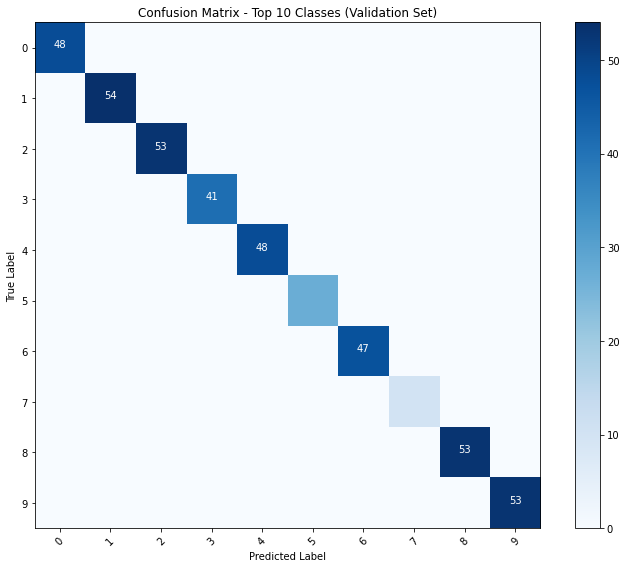

In [4]:
# Select top N classes based on frequency in the validation set
top_n = 10

# Get the count of each label in validation predictions or labels (using all labels)
val_label_counts = np.bincount(val_labels, minlength=num_classes)
top_indices = np.argsort(val_label_counts)[::-1][:top_n]

# Create a confusion matrix subset for the top N classes
cm_subset = cm[top_indices, :][:, top_indices]

plt.figure(figsize=(10, 8))
plt.imshow(cm_subset, interpolation="nearest", cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - Top {top_n} Classes (Validation Set)")
plt.colorbar()
tick_marks = np.arange(top_n)
plt.xticks(tick_marks, tick_marks, rotation=45)
plt.yticks(tick_marks, tick_marks)

# Optionally, annotate cells only for the subset.
thresh = cm_subset.max() / 2.
for i in range(cm_subset.shape[0]):
    for j in range(cm_subset.shape[1]):
        # Only annotate non-zero cells if you want to further reduce rendering time:
        if cm_subset[i, j] > thresh:
            plt.text(j, i, format(cm_subset[i, j], 'd'), horizontalalignment="center",
                     color="white")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

Dataset loaded successfully.
After filtering, 3000000 samples remain with 22555 unique labels.
Number of classes after filtering: 22555
Loaded tokenized texts from saved file.
Vocabulary size: 489792
Training samples: 2400000, Validation samples: 600000

Dataset Information:
Total samples: 3000000
Training samples: 2400000
Validation samples: 600000
Unique labels: 22555
Label distribution in full dataset:
heart rate variability                        268
adrenergic receptor                           268
myocardial scintigraphy                       268
erythrocyte deformability                     268
southern blot                                 268
                                             ... 
patient treatment file                          6
accommodative convergence to accommodation      6
multisomatoform disorder                        6
malignancyassociated changes                    6
aminohydroxypropylidene diphosphonate           6
Name: LABEL, Length: 22555, dtype: int64


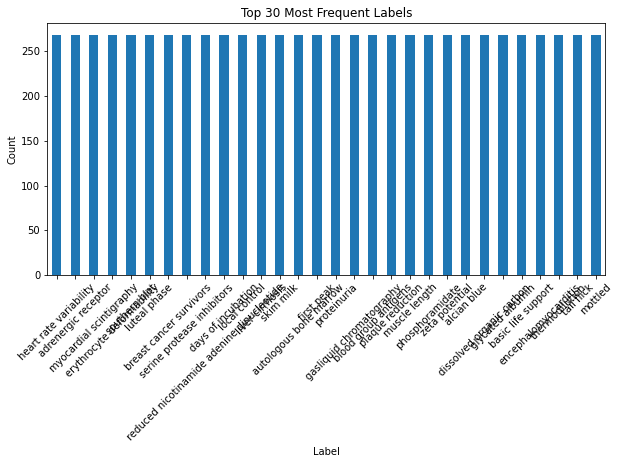

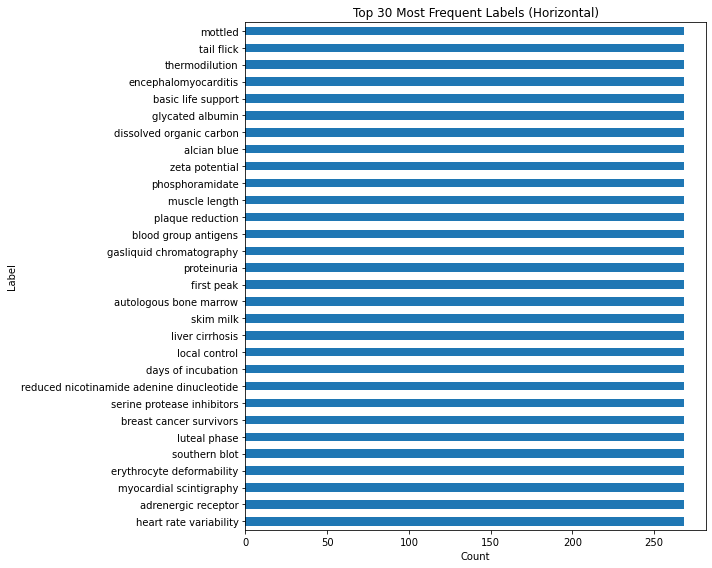

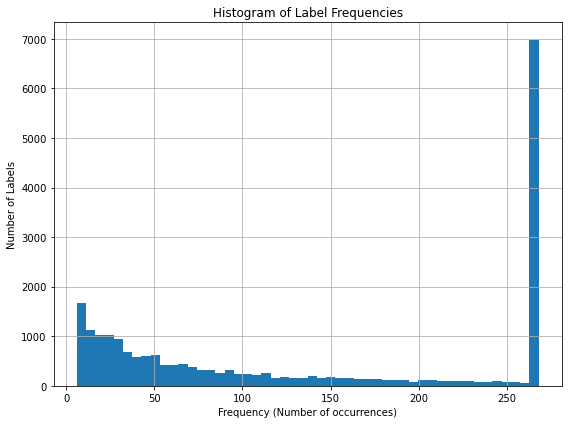

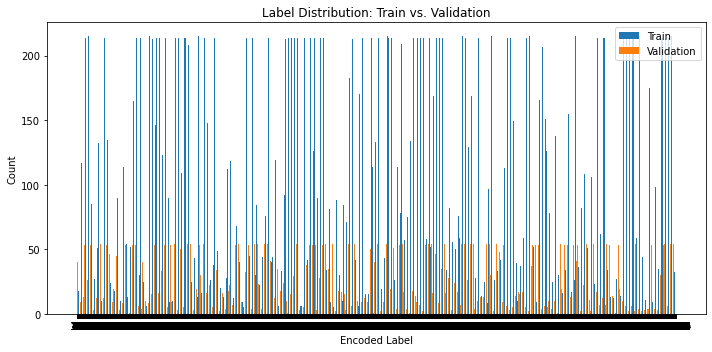

Loaded 400000 word vectors from GloVe.
LSTMClassifier(
  (embedding): Embedding(489792, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=22555, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch 1/10:
  Train - Loss: 1.2128, Acc: 64.75%, Prec: 0.4994, Rec: 0.4771, F1: 0.4437
  Val   - Loss: 1.2773, Acc: 63.42%, Prec: 0.4643, Rec: 0.4645, F1: 0.4297
Epoch 2/10:
  Train - Loss: 0.7890, Acc: 75.46%, Prec: 0.6353, Rec: 0.6017, F1: 0.5818
  Val   - Loss: 0.8942, Acc: 72.92%, Prec: 0.5868, Rec: 0.5765, F1: 0.5537
Epoch 3/10:
  Train - Loss: 0.6248, Acc: 80.04%, Prec: 0.7006, Rec: 0.6632, F1: 0.6496
  Val   - Loss: 0.7669, Acc: 76.52%, Prec: 0.6396, Rec: 0.6260, F1: 0.6087
Epoch 4/10:
  Train - Loss: 0.5359, Acc: 82.77%, Prec: 0.7420, Rec: 0.7029, F1: 0.6927
  Val   - Loss: 0.7127, Acc: 78.41%, Prec: 0.6727, Rec: 0.6564, F1: 0.6426
Epoch 5/10:
  Train - Loss: 0.4619, Acc: 84.89

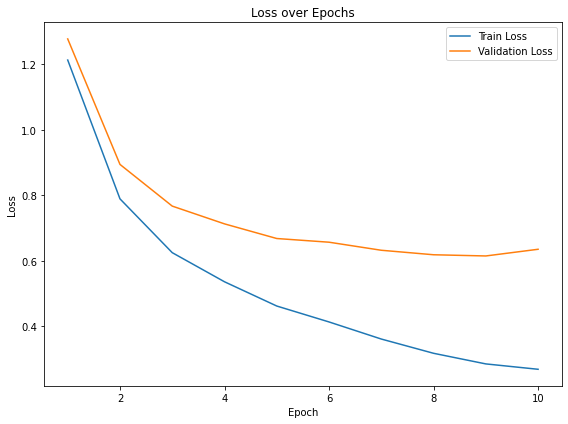

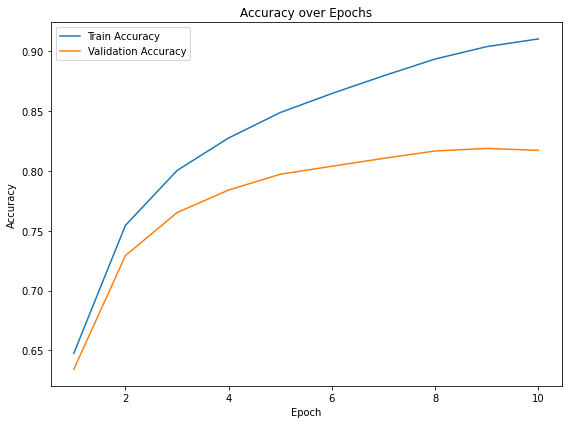

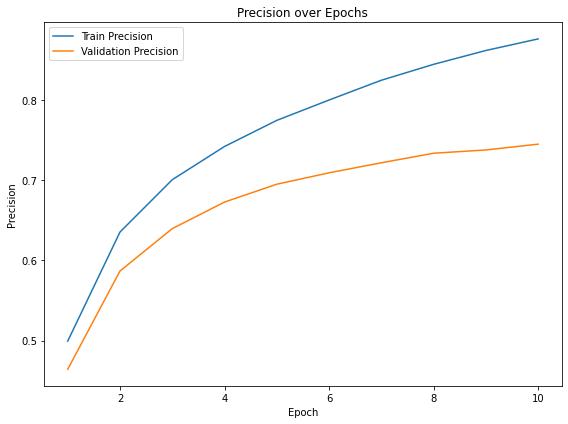

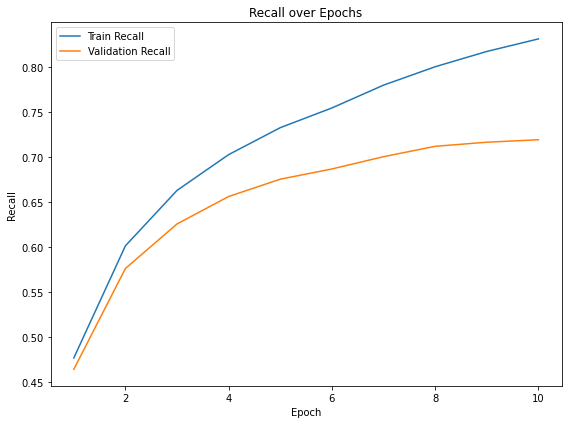

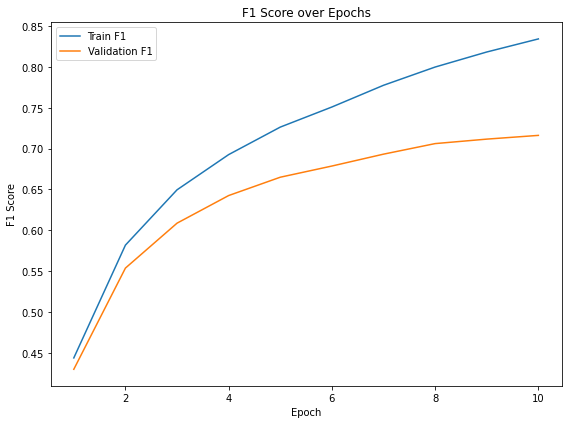

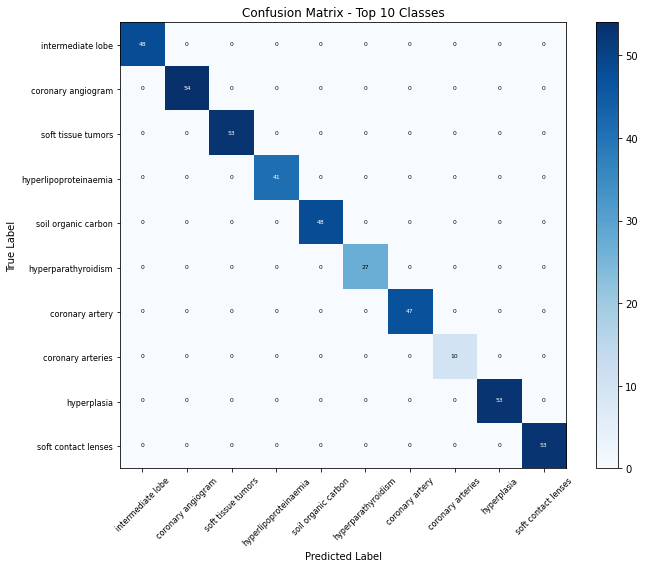


For the text: 'The patient was diagnosed with acute MI and was admitted to the ICU for further monitoring.' with abbreviation at position 6, predicted expansion is: meconium ileus


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from collections import Counter
import random
import spacy
import os
import zipfile
import matplotlib.pyplot as plt
import pickle  # For saving and loading tokenized texts

# -------------------------------
# Set random seeds for reproducibility
# -------------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# -------------------------------
# Load spaCy English model (disabling parser and NER to speed up tokenization)
# -------------------------------
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# -------------------------------
# Unzip the dataset files if needed
# -------------------------------
if not os.path.exists("train.csv"):
    with zipfile.ZipFile('train.csv.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
if not os.path.exists("train.csv"):
    with zipfile.ZipFile('archive (3).zip', 'r') as zip_ref:
        zip_ref.extractall('.')

# =======================
# Step 1: Load the Dataset
# =======================
try:
    df = pd.read_csv('train.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'train.csv' not found. Please ensure the dataset is in the working directory.")
    exit()

# -------------------------------
# Reduce the dataset size for development (maximum 3M samples)
# -------------------------------
max_samples = 3000000
if len(df) > max_samples:
    df = df.sample(n=max_samples, random_state=42).reset_index(drop=True)
    print(f"Dataset reduced to {len(df)} samples.")

# ================================
# Step 2: Preprocess and Clean Data
# ================================
df = df.dropna(subset=['TEXT', 'LABEL', 'LOCATION'])
df['LOCATION'] = df['LOCATION'].astype(int)

# Filter out rare labels (keep those that appear at least 5 times)
min_label_freq = 5
label_counts = df['LABEL'].value_counts()
valid_labels = label_counts[label_counts >= min_label_freq].index
df = df[df['LABEL'].isin(valid_labels)].reset_index(drop=True)
print(f"After filtering, {len(df)} samples remain with {df['LABEL'].nunique()} unique labels.")

# --- Advanced Preprocessing Functions ---
def extract_context(text, location, window_size=50):
    """
    Extract a window of tokens around the abbreviation.
    Assumes LOCATION is based on simple whitespace tokenization.
    """
    tokens = text.split()
    start = max(0, location - window_size // 2)
    end = min(len(tokens), location + window_size // 2)
    return " ".join(tokens[start:end])

# Extract context for each sample
contexts = [extract_context(text, loc, window_size=50) for text, loc in zip(df['TEXT'], df['LOCATION'])]
df['CONTEXT'] = contexts

texts = df['CONTEXT'].tolist()
labels = df['LABEL'].tolist()

# ===============================
# Step 3: Encode Labels
# ===============================
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
print(f"Number of classes after filtering: {num_classes}")

# ============================================
# Step 4: Tokenization and Vocabulary Construction
# ============================================
def batch_advanced_tokenize(texts, batch_size=1000):
    tokenized_texts = []
    for doc in nlp.pipe(texts, batch_size=batch_size):
        # Filter out punctuation and spaces
        tokens = [token.text for token in doc if not token.is_punct and not token.is_space]
        tokenized_texts.append(tokens)
    return tokenized_texts

# Try loading saved tokenized texts; if not present, tokenize and save.
if os.path.exists("tokenized_texts.pkl"):
    with open("tokenized_texts.pkl", "rb") as f:
        tokenized_texts = pickle.load(f)
    print("Loaded tokenized texts from saved file.")
else:
    tokenized_texts = batch_advanced_tokenize(texts, batch_size=1000)
    print("Tokenization complete.")
    with open("tokenized_texts.pkl", "wb") as f:
        pickle.dump(tokenized_texts, f)
    print("Tokenized texts saved successfully.")

# Build vocabulary from tokenized texts.
all_tokens = [token for tokens in tokenized_texts for token in tokens]
vocab_counter = Counter(all_tokens)
min_word_freq = 2
vocab = {token for token, count in vocab_counter.items() if count >= min_word_freq}

# Reserve indices: 0 for padding and 1 for unknown tokens.
word_to_index = {"<PAD>": 0, "<UNK>": 1}
for word in sorted(vocab):
    word_to_index[word] = len(word_to_index)
vocab_size = len(word_to_index)
print(f"Vocabulary size: {vocab_size}")

# Convert tokenized texts to sequences of indices.
def text_to_sequence(tokens):
    return [word_to_index.get(token, word_to_index["<UNK>"]) for token in tokens]

sequences = [text_to_sequence(tokens) for tokens in tokenized_texts]

# ===========================
# Step 5: Pad Sequences
# ===========================
max_len = 256  # Fixed maximum sequence length.
def pad_sequence_fn(seq, max_len):
    return seq + [0]*(max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

padded_sequences = [pad_sequence_fn(seq, max_len) for seq in sequences]
X = np.array(padded_sequences)
y = np.array(labels_encoded)

# ==================================
# Step 6: Train/Validation Data Split
# ==================================
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# ---------------------------
# Dataset Information & Label Distribution Plots
# ---------------------------
print("\nDataset Information:")
print("Total samples:", len(df))
print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))
print("Unique labels:", num_classes)
print("Label distribution in full dataset:")
print(df['LABEL'].value_counts())

# Plot overall label distribution (vertical bar chart) for the top N labels
top_n = 30
top_counts = df['LABEL'].value_counts().head(top_n)
plt.figure(figsize=(10, 5))
top_counts.plot(kind='bar')
plt.title(f"Top {top_n} Most Frequent Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25, top=0.95)  # adjust margins for readability
plt.show()

# Horizontal bar chart for the top N labels
plt.figure(figsize=(10, 8))
top_counts.plot(kind='barh')
plt.title(f"Top {top_n} Most Frequent Labels (Horizontal)")
plt.xlabel("Count")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

# Histogram of label frequencies (for all labels)
plt.figure(figsize=(8, 6))
df['LABEL'].value_counts().hist(bins=50)
plt.title("Histogram of Label Frequencies")
plt.xlabel("Frequency (Number of occurrences)")
plt.ylabel("Number of Labels")
plt.tight_layout()
plt.show()

# Also plot train vs. validation label distribution (using encoded labels)
train_label_counts = pd.Series(y_train).value_counts().sort_index()
val_label_counts = pd.Series(y_val).value_counts().sort_index()
indices = np.arange(num_classes)

plt.figure(figsize=(10, 5))
width = 0.35
plt.bar(indices - width/2, train_label_counts.values, width=width, label="Train")
plt.bar(indices + width/2, val_label_counts.values, width=width, label="Validation")
plt.title("Label Distribution: Train vs. Validation")
plt.xlabel("Encoded Label")
plt.ylabel("Count")
plt.xticks(indices, indices)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ============================================
# Step 7: Create PyTorch Dataset and DataLoader
# ============================================
class MedicalAbbrDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

batch_size = 64
train_dataset = MedicalAbbrDataset(X_train, y_train)
val_dataset = MedicalAbbrDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)

# ============================================
# Step 8: Load Pre-trained GloVe Embeddings and Build Embedding Matrix
# ============================================
def load_glove_embeddings(filepath, embedding_dim):
    embeddings_index = {}
    with open(filepath, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if vector.shape[0] == embedding_dim:
                embeddings_index[word] = vector
    return embeddings_index

embedding_dim = 100
glove_path = "glove.6B.100d.txt"
if not os.path.exists(glove_path):
    raise FileNotFoundError(f"{glove_path} not found. Please download it and place it in the working directory.")

glove_embeddings = load_glove_embeddings(glove_path, embedding_dim)
print(f"Loaded {len(glove_embeddings)} word vectors from GloVe.")

embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype=np.float32)
for word, idx in word_to_index.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

# ============================================
# Step 9: Define the LSTM-only Model (No Attention)
# ============================================
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout=0.3,
                 pretrained_embeddings=None, freeze_embeddings=False):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.tensor(pretrained_embeddings))
            self.embedding.weight.requires_grad = not freeze_embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, 
                            dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        lstm_out, (h_n, _) = self.lstm(embedded)
        # Concatenate final forward and backward hidden states
        forward_h = h_n[-2, :, :]
        backward_h = h_n[-1, :, :]
        hidden = torch.cat((forward_h, backward_h), dim=1)
        hidden = self.dropout(hidden)
        logits = self.fc(hidden)
        return logits

hidden_dim = 128
num_layers = 2
output_dim = num_classes
dropout = 0.3

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout,
                       pretrained_embeddings=embedding_matrix, freeze_embeddings=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

# ============================================
# Step 10: Define Loss, Optimizer, and Metrics Functions
# ============================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def compute_metrics(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = epoch_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    correct = 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
    avg_loss = running_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

# ============================================
# Step 11: Training Loop with Metrics Recording
# ============================================
num_epochs = 10
train_losses, train_accuracies = [], []
train_precisions, train_recalls, train_f1s = [], [], []
val_losses, val_accuracies = [], []
val_precisions, val_recalls, val_f1s = [], [], []

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate on training set
    tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, _, _ = compute_metrics(model, train_loader, criterion, device)
    # Evaluate on validation set
    val_loss, val_acc, val_prec, val_rec, val_f1, val_preds, val_labels = compute_metrics(model, val_loader, criterion, device)
    
    train_losses.append(tr_loss)
    train_accuracies.append(tr_acc)
    train_precisions.append(tr_prec)
    train_recalls.append(tr_rec)
    train_f1s.append(tr_f1)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_f1s.append(val_f1)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train - Loss: {tr_loss:.4f}, Acc: {tr_acc*100:.2f}%, Prec: {tr_prec:.4f}, Rec: {tr_rec:.4f}, F1: {tr_f1:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}")

# ============================================
# Step 12: Plot Metrics Over Epochs
# ============================================
epochs_arr = np.arange(1, num_epochs+1)

# Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_arr, train_losses, label="Train Loss")
plt.plot(epochs_arr, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

# Accuracy Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_arr, train_accuracies, label="Train Accuracy")
plt.plot(epochs_arr, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

# Precision Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_arr, train_precisions, label="Train Precision")
plt.plot(epochs_arr, val_precisions, label="Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

# Recall Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_arr, train_recalls, label="Train Recall")
plt.plot(epochs_arr, val_recalls, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

# F1 Score Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_arr, train_f1s, label="Train F1")
plt.plot(epochs_arr, val_f1s, label="Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================
# Step 13: Confusion Matrix Visualization
# ============================================
# Define the number of top classes to visualize
top_n = 10

# Compute the confusion matrix for the validation set
cm = confusion_matrix(val_labels, val_preds)

# Compute the frequency of each label in the validation set
val_label_counts = np.bincount(val_labels, minlength=num_classes)

# Get the indices of the top N most frequent classes
top_indices = np.argsort(val_label_counts)[::-1][:top_n]

# Create a subset confusion matrix for the top N classes
cm_subset = cm[top_indices, :][:, top_indices]

# Get the corresponding text labels from the label encoder
# label_encoder.classes_ is an array of all label names in the order of the encoded index.
text_labels = label_encoder.inverse_transform(top_indices)

# Plot the subset confusion matrix with text labels
plt.figure(figsize=(10, 8))
plt.imshow(cm_subset, interpolation="nearest", cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - Top {top_n} Classes")
plt.colorbar()

# Create tick marks and set them to the text labels
tick_marks = np.arange(top_n)
plt.xticks(tick_marks, text_labels, rotation=45, fontsize=8)
plt.yticks(tick_marks, text_labels, fontsize=8)

# Optionally, annotate each cell. (This can be slow if you have many cells.)
thresh = cm_subset.max() / 2.
for i in range(cm_subset.shape[0]):
    for j in range(cm_subset.shape[1]):
        plt.text(j, i, format(cm_subset[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_subset[i, j] > thresh else "black",
                 fontsize=6)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# ============================================
# Step 14: Inference Function and Example Inference
# ============================================
def predict_abbreviation(model, text, location, word_to_index, max_len, device, label_encoder):
    context = extract_context(text, location, window_size=50)
    # Tokenize the context (using spaCy)
    tokens = [token.text for token in nlp(context) if not token.is_punct and not token.is_space]
    seq = [word_to_index.get(token, word_to_index["<UNK>"]) for token in tokens]
    seq = pad_sequence_fn(seq, max_len)
    input_tensor = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
    pred_class = logits.argmax(dim=1).item()
    pred_label = label_encoder.inverse_transform([pred_class])[0]
    return pred_label

# Example Inference
sample_text = "The patient was diagnosed with acute MI and was admitted to the ICU for further monitoring."
sample_location = 6
predicted_expansion = predict_abbreviation(model, sample_text, sample_location, word_to_index, max_len, device, label_encoder)
print(f"\nFor the text: '{sample_text}' with abbreviation at position {sample_location}, predicted expansion is: {predicted_expansion}")

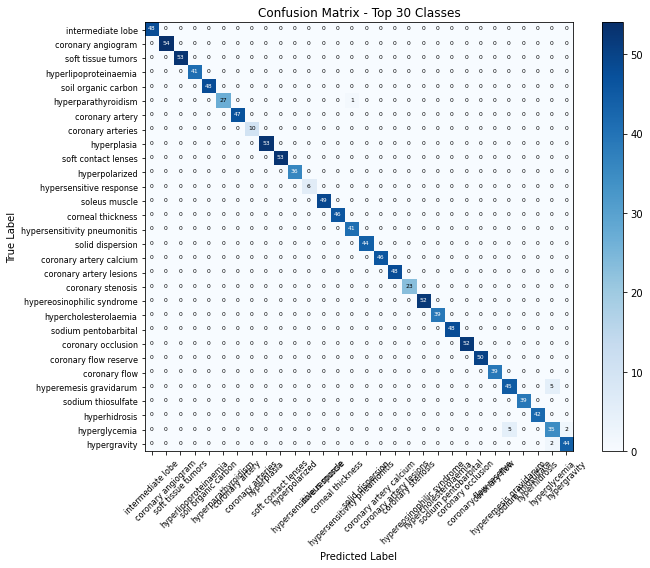

In [2]:
# Define the number of top classes to visualize
top_n = 30

# Compute the confusion matrix for the validation set
cm = confusion_matrix(val_labels, val_preds)

# Compute the frequency of each label in the validation set
val_label_counts = np.bincount(val_labels, minlength=num_classes)

# Get the indices of the top N most frequent classes
top_indices = np.argsort(val_label_counts)[::-1][:top_n]

# Create a subset confusion matrix for the top N classes
cm_subset = cm[top_indices, :][:, top_indices]

# Get the corresponding text labels from the label encoder
# label_encoder.classes_ is an array of all label names in the order of the encoded index.
text_labels = label_encoder.inverse_transform(top_indices)

# Plot the subset confusion matrix with text labels
plt.figure(figsize=(10, 8))
plt.imshow(cm_subset, interpolation="nearest", cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - Top {top_n} Classes")
plt.colorbar()

# Create tick marks and set them to the text labels
tick_marks = np.arange(top_n)
plt.xticks(tick_marks, text_labels, rotation=45, fontsize=8)
plt.yticks(tick_marks, text_labels, fontsize=8)

# Optionally, annotate each cell. (This can be slow if you have many cells.)
thresh = cm_subset.max() / 2.
for i in range(cm_subset.shape[0]):
    for j in range(cm_subset.shape[1]):
        plt.text(j, i, format(cm_subset[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_subset[i, j] > thresh else "black",
                 fontsize=6)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

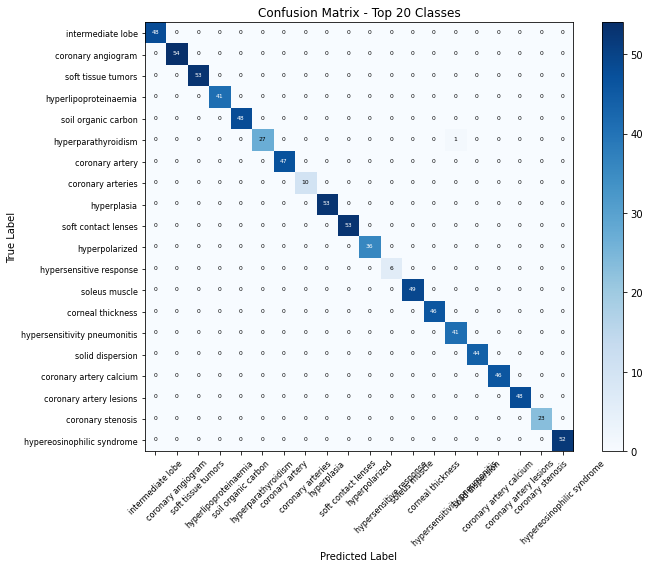

In [3]:
# Define the number of top classes to visualize
top_n = 20

# Compute the confusion matrix for the validation set
cm = confusion_matrix(val_labels, val_preds)

# Compute the frequency of each label in the validation set
val_label_counts = np.bincount(val_labels, minlength=num_classes)

# Get the indices of the top N most frequent classes
top_indices = np.argsort(val_label_counts)[::-1][:top_n]

# Create a subset confusion matrix for the top N classes
cm_subset = cm[top_indices, :][:, top_indices]

# Get the corresponding text labels from the label encoder
# label_encoder.classes_ is an array of all label names in the order of the encoded index.
text_labels = label_encoder.inverse_transform(top_indices)

# Plot the subset confusion matrix with text labels
plt.figure(figsize=(10, 8))
plt.imshow(cm_subset, interpolation="nearest", cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - Top {top_n} Classes")
plt.colorbar()

# Create tick marks and set them to the text labels
tick_marks = np.arange(top_n)
plt.xticks(tick_marks, text_labels, rotation=45, fontsize=8)
plt.yticks(tick_marks, text_labels, fontsize=8)

# Optionally, annotate each cell. (This can be slow if you have many cells.)
thresh = cm_subset.max() / 2.
for i in range(cm_subset.shape[0]):
    for j in range(cm_subset.shape[1]):
        plt.text(j, i, format(cm_subset[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_subset[i, j] > thresh else "black",
                 fontsize=6)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()